 ## Predict Future Sales: 회귀문제, RMSE로 평가

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib import font_manager, rc  #한글 폰트를 설정하기 위함.
%matplotlib inline

# 한글 폰트 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
    
rc('axes', unicode_minus=False)

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb 
import xgboost as xgb 
from catboost import CatBoostRegressor 
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier

In [4]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
clfs = []
CB = CatBoostRegressor(random_state = 0) ; clfs.append(CB)
RF = RandomForestClassifier(random_state = 0); clfs.append(RF)
GBM = GradientBoostingClassifier(random_state = 0); clfs.append(GBM)
LGBM = LGBMRegressor(random_state = 0); clfs.append(LGBM)
XGB = XGBRegressor() ; clfs.append(XGB)
for clf in clfs : 
    name = type(clf).__name__
    print(name)

CatBoostRegressor
RandomForestClassifier
GradientBoostingClassifier
LGBMRegressor
XGBRegressor


## 5개 모델

In [3]:
lgbm = pd.read_csv('lgbm_sub.csv')['item_cnt_month'] #light gradient boosting model.
xgb = pd.read_csv('xgb_sub.csv')['item_cnt_month']
ada = pd.read_csv('ada_sub.csv')['item_cnt_month']
rf = pd.read_csv('randomforest_sub.csv')['item_cnt_month']
linear = pd.read_csv('linear_sub.csv')['item_cnt_month']

submission = pd.read_csv('catboost_sub.csv')

In [4]:
model_name2 = ["randomforest","ada", "linear","lgbm", "xgb"]
model_size2 = len(model_name2)

In [5]:
regression_ensemble2 = pd.concat([lgbm, xgb, linear,ada, rf], axis = 1)
regression_ensemble2.columns = ["lgbm", "xgb", "linear","ada", "randomforest"]
regression_ensemble2

,lgbm,xgb,linear,ada,randomforest
0,0.492180,0.435173,0.865582,0.467286,0.160000
1,1.721019,0.339557,0.109227,0.146498,0.054289
2,0.961677,0.807810,1.081977,0.645642,1.000000
3,0.675906,0.378088,0.216395,0.177037,0.879205
4,3.661156,4.806588,0.109227,0.146498,0.046681
...,...,...,...,...,...
214195,0.115096,0.087205,0.199424,0.296735,1.000000
214196,0.028545,0.022706,0.081777,0.146498,0.029856
214197,0.062870,0.045608,0.081777,0.146498,0.240000
214198,0.014998,0.024647,0.081777,0.146498,0.051823


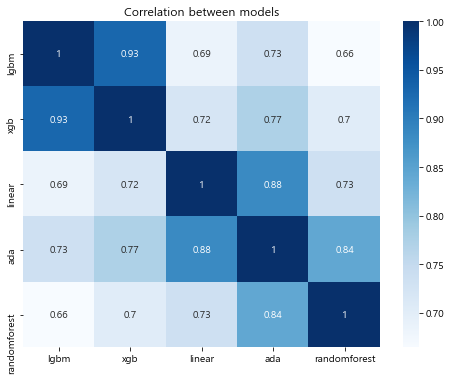

In [6]:
plt.figure(figsize = (8,6))
g = sns.heatmap(regression_ensemble2.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

In [7]:
def return_average(t,model_name1,model_name2):
    if t=="산술":
        df = (regression_ensemble2[model_name1]+regression_ensemble2[model_name2])/2
    
    elif t=="가중":
        score = {"randomforest" : 1.21174,
        "linear": 1.05424,
        "ada" : 1.02655,
        "xgb" : 0.87816,
        "lgbm" : 0.83794}
        df = (regression_ensemble2[model_name1]*score[model_name1]+regression_ensemble2[model_name2]*score[model_name2])/(score[model_name1]+score[model_name2])
    elif t=="기하":
        df = np.sqrt(regression_ensemble2[model_name1]*regression_ensemble2[model_name2])
    elif t == "멱" :
        df = np.sqrt((regression_ensemble2[model_name1]**2 + regression_ensemble2[model_name2]**2)/2)
        
    return pd.DataFrame(df,columns=[t + "item_cnt_month"])

In [8]:
#상관관계가 낮은 쌍부터 정렬
L=[]
for j in range(model_size2):
    for i in range(j + 1,model_size2):
        corr_value = regression_ensemble2.corr().iloc[:,j][i]
        L.append([corr_value,(model_name2[i],model_name2[j])])
        
L.sort()

In [9]:
L

[[0.6645119400858575, ('xgb', 'randomforest')],
 [0.6851222415980449, ('linear', 'randomforest')],
 [0.7028486806210192, ('xgb', 'ada')],
 [0.7216313614141201, ('linear', 'ada')],
 [0.7340417853136535, ('xgb', 'linear')],
 [0.7346767912068563, ('lgbm', 'randomforest')],
 [0.7738037543774698, ('lgbm', 'ada')],
 [0.8424070382222819, ('xgb', 'lgbm')],
 [0.8836608535039673, ('lgbm', 'linear')],
 [0.9290565233780312, ('ada', 'randomforest')]]

## 1. 상관관계가 가장 낮은 두 모델의 averageing

In [15]:
cnt=1
for corr_val,names in L[:cnt]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"XGB,RFsubmission.csv",header=True, index=False)

xgb randomforest


,산술item_cnt_month
0,0.297587
1,0.196923
2,0.903905
3,0.628646
4,2.426634
...,...
214195,0.543603
214196,0.026281
214197,0.142804
214198,0.038235


,가중item_cnt_month
0,0.275626
1,0.174156
2,0.919243
3,0.668639
4,2.046757
...,...
214195,0.616451
214196,0.026852
214197,0.158318
214198,0.040404


,기하item_cnt_month
0,0.263871
1,0.135772
2,0.898782
3,0.576556
4,0.473683
...,...
214195,0.295305
214196,0.026037
214197,0.104623
214198,0.035739


,멱item_cnt_month
0,0.327854
1,0.243152
2,0.908998
3,0.676739
4,3.398931
...,...
214195,0.709790
214196,0.026523
214197,0.172743
214198,0.040577


### xgb, rf

"xgb" : 0.87816   
"randomforest" : 1.21174   

xgb,rf lowest correlation 산술 score : 0.98024    
xgb,rf lowest correlation 멱 score : 0.99348    
xgb,rf lowest correlation 가중 score : 1.00996    
xgb,rf lowest correlation 기하 score :1.01184    
   
1. xgb와 rf 모델 중에서는 산술평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 0.98024    
2. xgb 자체의 성능이 이미 너무 좋았어서 그런지 xgb보다는 성능이 조금 떨어진다. rf의 점수 보다는 훨씬 좋아졌다.   
xgb의 경우 : -0.10208   
randomforest의 경우: 0.2315

## 2. 상관관계가 두번째로 낮고 성능이 가장 좋지 않은 두 모델의 averageing 

linear과 randomforest는 서로의 상관관계가 낮을 뿐만아니라, 성능이 가장 좋지 않은 두 모델이기도 하다.

In [25]:
for corr_val,names in L[1:2]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"linear,rfsubmission.csv",header=True, index=False)

linear randomforest


,산술item_cnt_month
0,0.512791
1,0.081758
2,1.040989
3,0.547800
4,0.077954
...,...
214195,0.599712
214196,0.055817
214197,0.160889
214198,0.066800


,가중item_cnt_month
0,0.488270
1,0.079849
2,1.038140
3,0.570835
4,0.075780
...,...
214195,0.627534
214196,0.054012
214197,0.166387
214198,0.065759


,기하item_cnt_month
0,0.372147
1,0.077005
2,1.040181
3,0.436183
4,0.071406
...,...
214195,0.446569
214196,0.049412
214197,0.140095
214198,0.065099


,멱item_cnt_month
0,0.622428
1,0.086249
2,1.041795
3,0.640245
4,0.083993
...,...
214195,0.721030
214196,0.061559
214197,0.179287
214198,0.068459


### linear, rf

"randomforest" : 1.21174   
"linear": 1.05424   

linear, rf 산술 score : 1.07061   
linear, rf 멱 score : 1.10118    
linear, rf 가중 score : 1.07671    
linear, rf 기하 score : 1.04743   
   
1. linear와 rf 모델 중에서는 기하 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 1.04743    
2. 두 가지 모델 다 성능이 좋은 편은 아니었어서 리더보드 점수가 각각의 단일모델만의 점수보다는 개선되었다.    
randomforest의 경우 0.16431   
linear의 경우 0.00681

## 3. 상관관계가 세 번째로 낮은 모델 averageing

In [17]:
for corr_val,names in L[2:3]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"xgb,adasubmission.csv",header=True, index=False)

xgb ada


,산술item_cnt_month
0,0.451230
1,0.243027
2,0.726726
3,0.277562
4,2.476543
...,...
214195,0.191970
214196,0.084602
214197,0.096053
214198,0.085572


,가중item_cnt_month
0,0.452481
1,0.235507
2,0.720409
3,0.269731
4,2.295016
...,...
214195,0.200132
214196,0.089424
214197,0.099983
214198,0.090319


,기하item_cnt_month
0,0.450944
1,0.223035
2,0.722188
3,0.258719
4,0.839140
...,...
214195,0.160863
214196,0.057675
214197,0.081740
214198,0.060089


,멱item_cnt_month
0,0.451515
1,0.261496
2,0.731235
3,0.295205
4,3.400349
...,...
214195,0.218697
214196,0.104827
214197,0.108494
214198,0.105046


### xgb, ada

"xgb" : 0.87816   
"ada" : 1.02655   
   
xgb, ada 산술 score :   
xgb, ada 멱 score : 0.90272   
xgb, ada 가중 score : 0.92712   
xgb, ada 기하 score : 0.97429   
   
1. xgb와 ada 모델 중에서는 멱 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 0.91301     
2. ada 모델의 성능은 개선되었지만, xgb 모델은 기존 모델의 성능이 좋은 편이어서 그런지 성능이 다소 떨어졌다.   
xgb의 경우    
ada의 경우 

## 4. 상관관계가 네 번째로 낮은 모델 averageing

In [12]:
for corr_val,names in L[3:4]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"linear, adasubmission.csv",header=True, index=False)

linear ada


,산술item_cnt_month
0,0.666434
1,0.127862
2,0.863810
3,0.196716
4,0.127862
...,...
214195,0.248080
214196,0.114138
214197,0.114138
214198,0.114138


,가중item_cnt_month
0,0.669084
1,0.127614
2,0.866713
3,0.196978
4,0.127614
...,...
214195,0.247432
214196,0.113707
214197,0.113707
214198,0.113707


,기하item_cnt_month
0,0.635983
1,0.126497
2,0.835805
3,0.195729
4,0.126497
...,...
214195,0.243261
214196,0.109454
214197,0.109454
214198,0.109454


,멱item_cnt_month
0,0.695553
1,0.129213
2,0.890935
3,0.197698
4,0.129213
...,...
214195,0.252806
214196,0.118636
214197,0.118636
214198,0.118636


### linear, ada

"linear": 1.05424   
"ada" : 1.02655   
   
linear, ada 산술 score : 1.02461   
linear, ada 멱 score : 1.02922   
linear, ada 가중 score : 1.02480   
linear, ada 기하 score : 1.02113   
   
1. linear와 ada 모델 중에서는 기하 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 1.02113    
2. linear 모델과 ada 모델의 성능이 모두 개선되었다.   
linear의 경우 0.03311   
ada의 경우 0.00542

## 5. 상관관계는 중간정도(5/10)로 높은 모델 averageing

xgb의 성능은 5개의 모델 중에서 2번쨰로 높고, linear 모델의 성능은 5개의 모델 중에서 4번째이다.

In [27]:
for corr_val,names in L[4:5]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"xgb,linearsubmission.csv",header=True, index=False)

xgb linear


,산술item_cnt_month
0,0.650378
1,0.224392
2,0.944893
3,0.297241
4,2.457907
...,...
214195,0.143315
214196,0.052242
214197,0.063693
214198,0.053212


,가중item_cnt_month
0,0.669987
1,0.213898
2,0.957385
3,0.289875
4,2.243896
...,...
214195,0.148427
214196,0.054933
214197,0.065340
214198,0.055815


,기하item_cnt_month
0,0.613741
1,0.192584
2,0.934897
3,0.286036
4,0.724575
...,...
214195,0.131874
214196,0.043091
214197,0.061071
214198,0.044895


,멱item_cnt_month
0,0.685058
1,0.252219
2,0.954786
3,0.308040
4,3.399648
...,...
214195,0.153907
214196,0.060013
214197,0.066210
214198,0.060395


### xgb, linear

"linear": 1.05424   
"xgb" : 0.87816   
   
xgb, linear 산술 score : 0.92677   
xgb, linear 멱 score : 0.91301   
xgb, linear 가중 score : 0.93529   
xgb, linear 기하 score : 0.97602   
   
1. xgb와 linear 모델 중에서는 멱 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 0.91301     
2. linear 모델의 성능은 개선되었지만, xgb 모델은 워낙 모델의 성능이 좋았어서 그런지 성능이 다소 떨어졌다.   
xgb의 경우 0.14123   
linear의 경우 -0.03485

## 6. 상관관계가 중간정도(6/10)인 모델의 averageing

In [11]:
for corr_val,names in L[5:6]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"lgbm,randomforestsubmission.csv",header=True, index=False)

lgbm randomforest


,산술item_cnt_month
0,0.326090
1,0.887654
2,0.980839
3,0.777555
4,1.853918
...,...
214195,0.557548
214196,0.029201
214197,0.151435
214198,0.033411


,가중item_cnt_month
0,0.295800
1,0.735673
2,0.984333
3,0.796093
4,1.524333
...,...
214195,0.638238
214196,0.029320
214197,0.167587
214198,0.036768


,기하item_cnt_month
0,0.280622
1,0.305666
2,0.980651
3,0.770882
4,0.413408
...,...
214195,0.339258
214196,0.029193
214197,0.122837
214198,0.027879


,멱item_cnt_month
0,0.365952
1,1.217549
2,0.981026
3,0.784171
4,2.589039
...,...
214195,0.711775
214196,0.029208
214197,0.175432
214198,0.038148


### lgbm, randomforest

"randomforest" : 1.21174   
"lgbm" : 0.83794   
    
lgbm, randomforest 산술 score : 0.94933   
lgbm, randomforest 멱 score : 0.95965   
lgbm, randomforest 가중 score : 0.98854   
lgbm, randomforest 기하 score : 0.99934   
   
1. lgbm와 randomforest 모델 중에서는 산술 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 0.94933     
2. randomforest 모델의 리더보드 점수는 매우 개선되었지만, 원래 성능이 좋았던 lgbm은 점수가 다소 떨어지게 되었다. 
lgbm의 경우 -0.11139   
randomforest의 경우 0.26241

## 7. 상관관계가 다소 높은 (7/10)인 모델의 averageing

In [13]:
for corr_val,names in L[6:7]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"lgbm,adasubmission.csv",header=True, index=False)

lgbm ada


,산술item_cnt_month
0,0.479733
1,0.933758
2,0.803660
3,0.426471
4,1.903827
...,...
214195,0.205916
214196,0.087521
214197,0.104684
214198,0.080748


,가중item_cnt_month
0,0.478474
1,0.854120
2,0.787675
3,0.401239
4,1.726057
...,...
214195,0.215103
214196,0.093487
214197,0.108914
214198,0.087399


,기하item_cnt_month
0,0.479572
1,0.502121
2,0.787972
3,0.345919
4,0.732361
...,...
214195,0.184805
214196,0.064667
214197,0.095971
214198,0.046875


,멱item_cnt_month
0,0.479895
1,1.221345
2,0.819047
3,0.494060
4,2.590900
...,...
214195,0.225054
214196,0.105538
214197,0.112726
214198,0.104131


### lgbm, ada

"lgbm" : 0.83794   
"ada" : 1.02655   
   
lgbm, ada 산술 score : 0.88611   
lgbm, ada 멱 score : 0.86107   
lgbm, ada 가중 score : 0.89662    
lgbm, ada 기하 score : 0.96118   
   
1. lgbm과 ada 모델 중에서는 멱 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 0.86107     
2. lgbm의 경우 성능이 기존에도 좋은 편이었어서 리더보드 점수가 다소 떨어졌지만, ada의 경우 리더보드의 점수가 큰 폭으로 개선되었다. 

lgbm의 경우 -0.02313   
ada의 경우 0.16548

## 8. 상관관계는 다소 높은 편이지만(8/10), 성능이 가장 좋았던 모델(lgbm, xgb)들의 averageing 결과

In [26]:
for corr_val,names in L[7:8]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"lgbm,xgbsubmission.csv",header=True, index=False)

xgb lgbm


,산술item_cnt_month
0,0.463677
1,1.030288
2,0.884743
3,0.526997
4,4.233872
...,...
214195,0.101151
214196,0.025626
214197,0.054239
214198,0.019823


,가중item_cnt_month
0,0.463009
1,1.014099
2,0.882940
3,0.523507
4,4.247295
...,...
214195,0.100824
214196,0.025557
214197,0.054037
214198,0.019936


,기하item_cnt_month
0,0.462800
1,0.764450
2,0.881392
3,0.505521
4,4.194957
...,...
214195,0.100185
214196,0.025459
214197,0.053548
214198,0.019227


,멱item_cnt_month
0,0.464552
1,1.240404
2,0.888082
3,0.547631
4,4.272432
...,...
214195,0.102107
214196,0.025791
214197,0.054921
214198,0.020401


### lgbm, xgb

"xgb" : 0.87816,   
"lgbm" : 0.83794   
   
xgb, lgbm 산술 score : 0.84515   
xgb, lgbm 멱 score : 0.84384   
xgb, lgbm 가중 score : 0.84569    
xgb, lgbm 기하 score : 0.84891   
   
1. xgb와 lgbm 모델 중에서는 멱 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 0.84384     
2. lgbm의 경우 성능이 기존에도 좋은 편이었어서 리더보드 점수가 개선되지 않았지만, xgb의 경우 기존의 점수가 좋았음에도 불구하고 리더보드 점수가 많이 개선된 것을 볼 수 있다.   
xgb의 경우 0.03432   
lgbm의 경우 -0.0059

## 9. 상관관계가 두 번째로 높은 (9/10)인 모델의 averageing

In [14]:
for corr_val,names in L[8:9]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"lgbm,linearsubmission.csv",header=True, index=False)

lgbm linear


,산술item_cnt_month
0,0.678881
1,0.915123
2,1.021827
3,0.446151
4,1.885191
...,...
214195,0.157260
214196,0.055161
214197,0.072324
214198,0.048388


,가중item_cnt_month
0,0.700223
1,0.822999
2,1.028703
3,0.419887
4,1.682176
...,...
214195,0.162080
214196,0.058204
214197,0.073404
214198,0.052205


,기하item_cnt_month
0,0.652704
1,0.433568
2,1.020055
3,0.382443
4,0.632374
...,...
214195,0.151502
214196,0.048315
214197,0.071703
214198,0.035022


,멱item_cnt_month
0,0.704086
1,1.219393
2,1.023596
3,0.501834
4,2.589980
...,...
214195,0.162814
214196,0.061247
214197,0.072939
214198,0.058790


### lgbm, linear

"linear": 1.05424
"lgbm" : 0.83794
   
lgbm, linear 산술 score : 0.89220   
lgbm, linear 멱 score : 0.87254   
lgbm, linear 가중 score : 0.90601   
lgbm, linear 기하 score : 0.96235   
   
1. lgbm, linear 모델 중에서는 멱 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 0.87254   
2. lgbm의 경우 리더보드의 점수가 다소 떨어졌지만, linear의 경우 리더보드 점수가 크게 개선된 것을 볼 수 있다.   
linear의 경우 0.1817   
lgbm의 경우 -0.0346

## 10. 상관관계가 가장 높은 모델들의 averageing

In [13]:
for corr_val,names in L[9:]:
    a,b = names
    print(a,b)
    for t in ["산술","가중","기하","멱"] : 
        df = return_average(t,a,b)
        display(df)
        submission["item_cnt_month"] = df[t+"item_cnt_month"]
        submission.to_csv(t+"ada,rfsubmission.csv",header=True, index=False)

ada randomforest


,산술item_cnt_month
0,0.313643
1,0.100393
2,0.822821
3,0.528121
4,0.096589
...,...
214195,0.648368
214196,0.088177
214197,0.193249
214198,0.099160


,가중item_cnt_month
0,0.300931
1,0.096579
2,0.837480
3,0.557169
4,0.092460
...,...
214195,0.677461
214196,0.083352
214197,0.197117
214198,0.095244


,기하item_cnt_month
0,0.273433
1,0.089181
2,0.803519
3,0.394527
4,0.082696
...,...
214195,0.544734
214196,0.066135
214197,0.187509
214198,0.087132


,멱item_cnt_month
0,0.349254
1,0.110474
2,0.841681
3,0.634170
4,0.108722
...,...
214195,0.737581
214196,0.105719
214197,0.198824
214198,0.109880


### ada, randomforest

"ada" : 1.02655   
"randomforest" : 1.21174   
   
ada, randomforest highest correlation 산술 score : 1.07187   
ada, randomforest highest correlation 멱 score : 1.09653   
ada, randomforest highest correlation 가중 score : 1.08019    
ada, randomforest highest correlation 기하 score : 1.05063   
   
1. ada와 randomforest모델 중에서는 기하 평균으로 낸 리더보드 점수가 가장 좋았다. 점수: 1.05063     
2. ada의 경우 리더보드의 점수가 다소 떨어졌지만, randomforest의 경우 리더보드 점수가 많이 개선된 것을 볼 수 있다.   
ada의 경우 -0.02408   
randomforest의 경우 0.16111

## 성능 전체 순위매기기

In [179]:
ensemble_scores={"XGB,RF 산술" : 0.98024,"LI,RF 기하" :1.04743, 
                 "XGB,ADA 멱" :0.90272, "LI,ADA 기하" : 1.02113,
                 "XGB,LI 멱" :0.91301,"LGBM,RF 산술" : 0.94933,  
                 "LGBM,ADA 멱" : 0.86107, "XGB,LGBM 멱" : 0.84384,
                 "LGBM,LI 멱" : 0.87254, "ADA,RF 기하" :1.05063}

In [180]:
ensemble_scores = sorted(ensemble_scores.items(), key=lambda x: x[1])
ensemble_df = pd.DataFrame(ensemble_scores)
ensemble_df.columns = ["model","averaging_score"]
ensemble_df

,model,averaging_score
0,"XGB,LGBM 멱",0.84384
1,"LGBM,ADA 멱",0.86107
2,"LGBM,LI 멱",0.87254
3,"XGB,ADA 멱",0.90272
4,"XGB,LI 멱",0.91301
5,"LGBM,RF 산술",0.94933
6,"XGB,RF 산술",0.98024
7,"LI,ADA 기하",1.02113
8,"LI,RF 기하",1.04743
9,"ADA,RF 기하",1.05063


In [181]:
ensemble_df["corr_score"]=[0.8424070382222819, 0.7738037543774698, 0.8836608535039673, 0.7028486806210192,
                          0.7340417853136535, 0.7346767912068563, 0.6645119400858575, 0.7216313614141201,
                          0.6851222415980449, 0.9290565233780312]
ensemble_df

,model,averaging_score,corr_score
0,"XGB,LGBM 멱",0.84384,0.842407
1,"LGBM,ADA 멱",0.86107,0.773804
2,"LGBM,LI 멱",0.87254,0.883661
3,"XGB,ADA 멱",0.90272,0.702849
4,"XGB,LI 멱",0.91301,0.734042
5,"LGBM,RF 산술",0.94933,0.734677
6,"XGB,RF 산술",0.98024,0.664512
7,"LI,ADA 기하",1.02113,0.721631
8,"LI,RF 기하",1.04743,0.685122
9,"ADA,RF 기하",1.05063,0.929057


In [182]:
ensemble_df["singlemodel1_score"] = [0.83794,0.83794,0.83794,0.87816,0.87816,0.83794,0.87816,1.02655,
                                    1.05424,1.02655]
ensemble_df["singlemodel2_score"] = [0.87816,1.02655,1.05424,1.02655,1.05424,1.21174,1.21174,1.05424,
                                    1.21174,1.21174]
ensemble_df

,model,averaging_score,corr_score,singlemodel1_score,singlemodel2_score
0,"XGB,LGBM 멱",0.84384,0.842407,0.83794,0.87816
1,"LGBM,ADA 멱",0.86107,0.773804,0.83794,1.02655
2,"LGBM,LI 멱",0.87254,0.883661,0.83794,1.05424
3,"XGB,ADA 멱",0.90272,0.702849,0.87816,1.02655
4,"XGB,LI 멱",0.91301,0.734042,0.87816,1.05424
5,"LGBM,RF 산술",0.94933,0.734677,0.83794,1.21174
6,"XGB,RF 산술",0.98024,0.664512,0.87816,1.21174
7,"LI,ADA 기하",1.02113,0.721631,1.02655,1.05424
8,"LI,RF 기하",1.04743,0.685122,1.05424,1.21174
9,"ADA,RF 기하",1.05063,0.929057,1.02655,1.21174


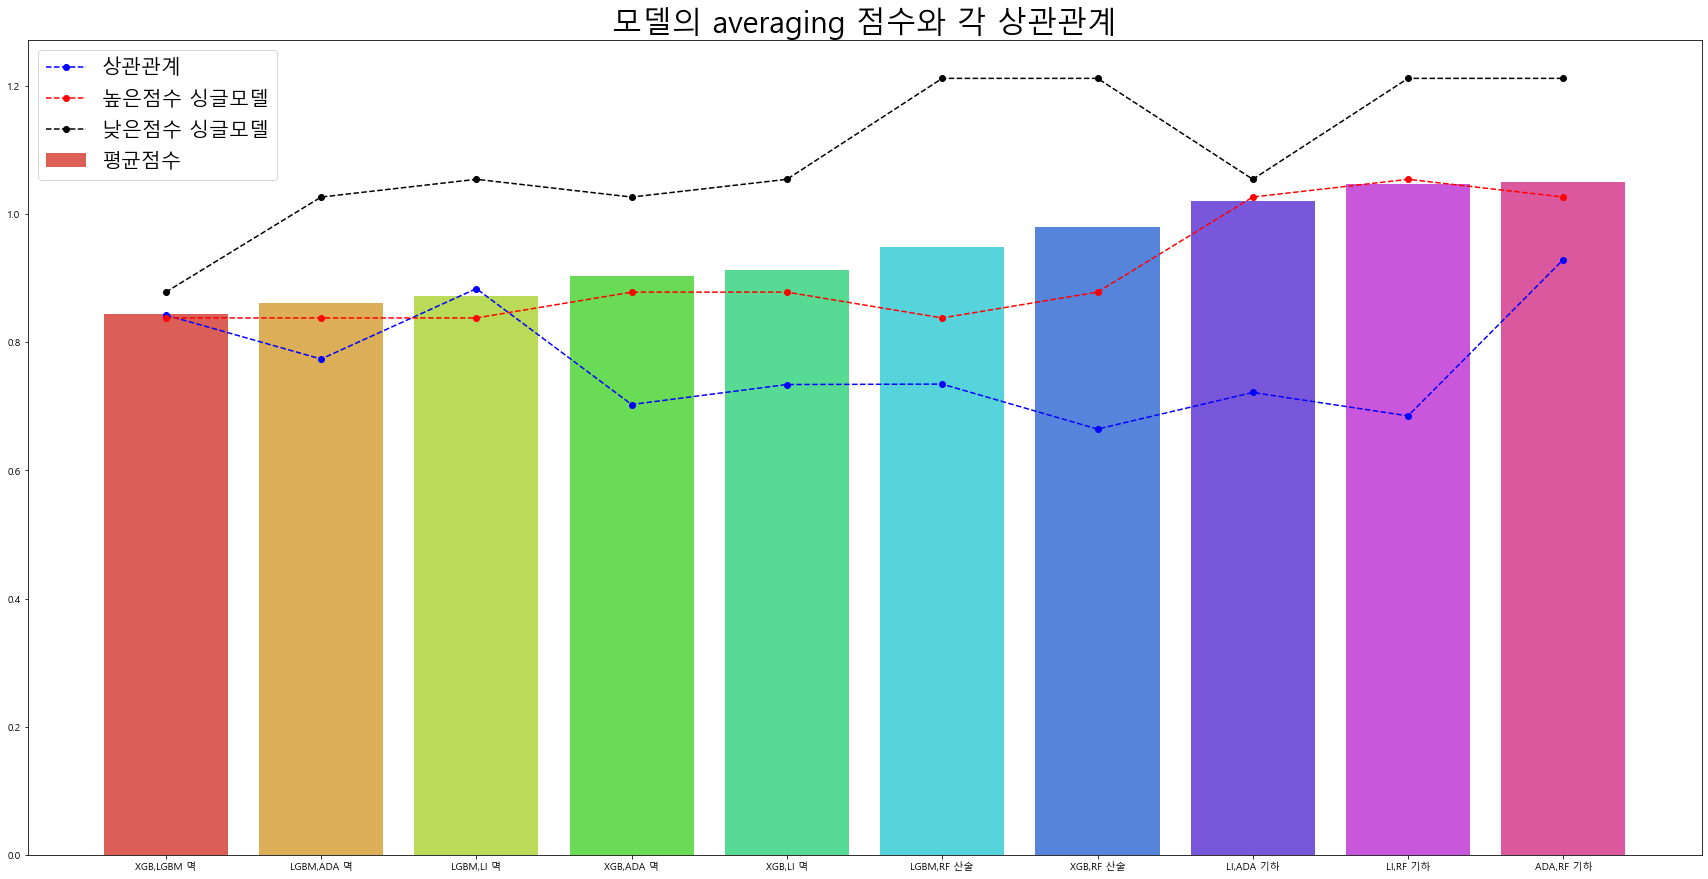

In [183]:
fig = plt.figure(figsize=(30,15))
colors = sns.color_palette('hls',len(ensemble_df["model"]))
plt.bar(ensemble_df["model"], ensemble_df["averaging_score"],label = "평균점수",color=colors) ## 바차트 출력
plt.plot(ensemble_df["model"], ensemble_df["corr_score"], color='b',
         linestyle='--', marker='o',label = "상관관계") ## 선 그래프 출력
plt.plot(ensemble_df["model"], ensemble_df["singlemodel1_score"], color='r',
         linestyle='--', marker='o',label = "높은점수 싱글모델") ## 선 그래프 출력
plt.plot(ensemble_df["model"], ensemble_df["singlemodel2_score"], color='black',
         linestyle='--', marker='o',label = "낮은점수 싱글모델") ## 선 그래프 출력

plt.title('모델의 averaging 점수와 각 상관관계', fontsize=30)
plt.legend(loc=0, fontsize = 20) #범례의 위치
plt.rc('xtick', labelsize = 23)
plt.rc('ytick', labelsize = 30)
plt.show()

In [184]:
ensemble_df["performance improvement"]=ensemble_df["averaging_score"]-ensemble_df["singlemodel1_score"]
ensemble_df

,model,averaging_score,corr_score,singlemodel1_score,singlemodel2_score,performance improvement
0,"XGB,LGBM 멱",0.84384,0.842407,0.83794,0.87816,0.00590
1,"LGBM,ADA 멱",0.86107,0.773804,0.83794,1.02655,0.02313
2,"LGBM,LI 멱",0.87254,0.883661,0.83794,1.05424,0.03460
3,"XGB,ADA 멱",0.90272,0.702849,0.87816,1.02655,0.02456
4,"XGB,LI 멱",0.91301,0.734042,0.87816,1.05424,0.03485
5,"LGBM,RF 산술",0.94933,0.734677,0.83794,1.21174,0.11139
6,"XGB,RF 산술",0.98024,0.664512,0.87816,1.21174,0.10208
7,"LI,ADA 기하",1.02113,0.721631,1.02655,1.05424,-0.00542
8,"LI,RF 기하",1.04743,0.685122,1.05424,1.21174,-0.00681
9,"ADA,RF 기하",1.05063,0.929057,1.02655,1.21174,0.02408


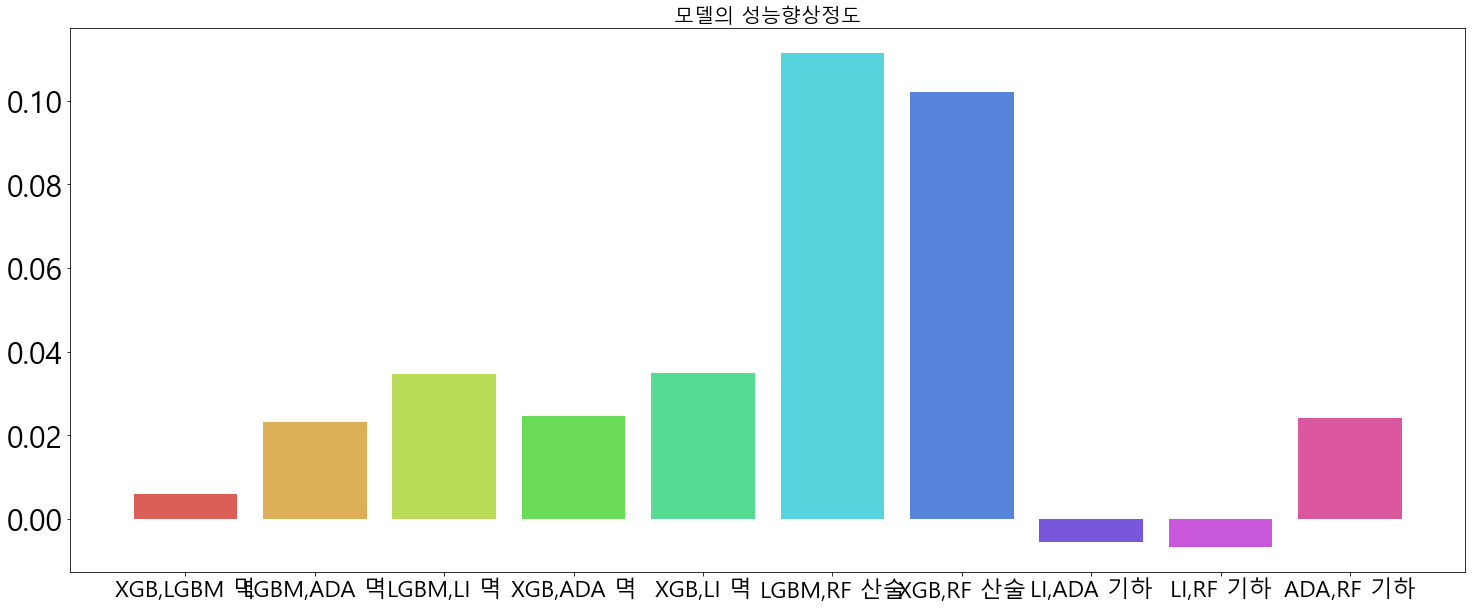

In [185]:
fig = plt.figure(figsize=(25,10))
plt.bar(ensemble_df["model"], ensemble_df["performance improvement"],label = "성능향상",color=colors)
plt.title('모델의 성능향상정도', fontsize=20) 
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 25)

## 위의 그래프는 아래로 내려가는게 성능이 향상 된 것임.

"randomforest" : 1.21174   
"linear": 1.05424   
"ada" : 1.02655   
"xgb" : 0.87816   
"lgbm" : 0.83794

결론 : 
1. 성능이 좋은 단일 모델들(lgbm, xgb)을 averageing 한 점수가 가장 높음
2. 상관관계가 가장 낮은 모델(xgb, randomforest)이라도 성능이 좋지 않으면 averageing을 하더라도 리더보드의 다른 averageing한 모델들 보다 좋은 점수가 나오진 않음.
3. 

In [186]:
ensemble_df

,model,averaging_score,corr_score,singlemodel1_score,singlemodel2_score,performance improvement
0,"XGB,LGBM 멱",0.84384,0.842407,0.83794,0.87816,0.00590
1,"LGBM,ADA 멱",0.86107,0.773804,0.83794,1.02655,0.02313
2,"LGBM,LI 멱",0.87254,0.883661,0.83794,1.05424,0.03460
3,"XGB,ADA 멱",0.90272,0.702849,0.87816,1.02655,0.02456
4,"XGB,LI 멱",0.91301,0.734042,0.87816,1.05424,0.03485
5,"LGBM,RF 산술",0.94933,0.734677,0.83794,1.21174,0.11139
6,"XGB,RF 산술",0.98024,0.664512,0.87816,1.21174,0.10208
7,"LI,ADA 기하",1.02113,0.721631,1.02655,1.05424,-0.00542
8,"LI,RF 기하",1.04743,0.685122,1.05424,1.21174,-0.00681
9,"ADA,RF 기하",1.05063,0.929057,1.02655,1.21174,0.02408


In [187]:
ensemble_df["SM12_score_mean"] = (ensemble_df["singlemodel1_score"]+ensemble_df["singlemodel2_score"])/2
ensemble_df

,model,averaging_score,corr_score,singlemodel1_score,singlemodel2_score,performance improvement,SM12_score_mean
0,"XGB,LGBM 멱",0.84384,0.842407,0.83794,0.87816,0.00590,0.858050
1,"LGBM,ADA 멱",0.86107,0.773804,0.83794,1.02655,0.02313,0.932245
2,"LGBM,LI 멱",0.87254,0.883661,0.83794,1.05424,0.03460,0.946090
3,"XGB,ADA 멱",0.90272,0.702849,0.87816,1.02655,0.02456,0.952355
4,"XGB,LI 멱",0.91301,0.734042,0.87816,1.05424,0.03485,0.966200
5,"LGBM,RF 산술",0.94933,0.734677,0.83794,1.21174,0.11139,1.024840
6,"XGB,RF 산술",0.98024,0.664512,0.87816,1.21174,0.10208,1.044950
7,"LI,ADA 기하",1.02113,0.721631,1.02655,1.05424,-0.00542,1.040395
8,"LI,RF 기하",1.04743,0.685122,1.05424,1.21174,-0.00681,1.132990
9,"ADA,RF 기하",1.05063,0.929057,1.02655,1.21174,0.02408,1.119145


In [188]:
ensemble_df["performance improvement2"] = ensemble_df["SM12_score_mean"]-ensemble_df["averaging_score"]
ensemble_df

,model,averaging_score,corr_score,singlemodel1_score,singlemodel2_score,performance improvement,SM12_score_mean,performance improvement2
0,"XGB,LGBM 멱",0.84384,0.842407,0.83794,0.87816,0.00590,0.858050,0.014210
1,"LGBM,ADA 멱",0.86107,0.773804,0.83794,1.02655,0.02313,0.932245,0.071175
2,"LGBM,LI 멱",0.87254,0.883661,0.83794,1.05424,0.03460,0.946090,0.073550
3,"XGB,ADA 멱",0.90272,0.702849,0.87816,1.02655,0.02456,0.952355,0.049635
4,"XGB,LI 멱",0.91301,0.734042,0.87816,1.05424,0.03485,0.966200,0.053190
5,"LGBM,RF 산술",0.94933,0.734677,0.83794,1.21174,0.11139,1.024840,0.075510
6,"XGB,RF 산술",0.98024,0.664512,0.87816,1.21174,0.10208,1.044950,0.064710
7,"LI,ADA 기하",1.02113,0.721631,1.02655,1.05424,-0.00542,1.040395,0.019265
8,"LI,RF 기하",1.04743,0.685122,1.05424,1.21174,-0.00681,1.132990,0.085560
9,"ADA,RF 기하",1.05063,0.929057,1.02655,1.21174,0.02408,1.119145,0.068515


In [197]:
ensemble_df['performance improvement2'].mean()

0.05753200000000003

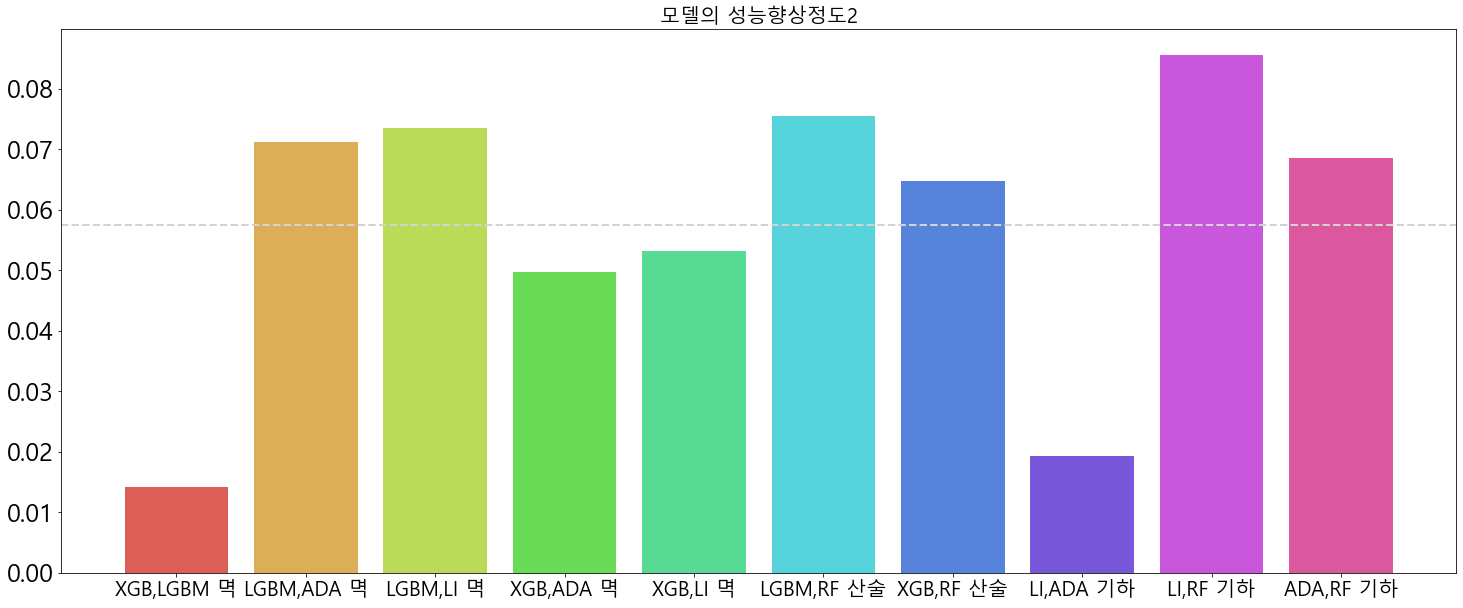

In [200]:
fig = plt.figure(figsize=(25,10))
plt.bar(ensemble_df["model"], ensemble_df["performance improvement2"],label = "성능향상",color=colors)
plt.title('모델의 성능향상정도2', fontsize=20) 
plt.axhline(0.05753200000000003,0 ,1, color='lightgray', linestyle='--', linewidth=2)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 25)

## 위의 그래프는 위로 올라가는 것이 성능이 향상 된 것임.

조합을 한 단일모델들의 리더보드 점수의 평균을 한 값보다는 성능이 향상했다는 것을 알 수 있다.    

이들의 평균보다 훨씬 더 향상한 모델들의 조합 = lgbm/ada, lgbm/linear, lgbm/rf, xgb/rf, linear/rf, ada/rf   

(lgbm과 xgb를 뺀 이유는 이미 성능이 좋은 모델이기 때문에 어떤 것과 조합하든 성능이 향상될 것이라고 판단했기 때문이다.)   
이 중에서 원래 단일모델들의 성능이 좋았던 lgbm과 xgb와 조합한 averaging을 빼면, linear과 rf, ada와 rf를 조합한 것이 남는다.    
[0.6851222415980449,('linear', 'randomforest')]   
의 경우에는 단일모델들 간의 상관관계가 두 번째로 낮은 조합이다. 이들의 성능은 5개의 단일모델들 중 각각 4,5등을 차지하고 있다.   
결론 : averaging은 단일모델들 간의 상관관계가 낮고 단일모델의 성능이 낮은 모델들을 조합하였을 때, 성능이 가장 큰 폭으로 향상한다는 것을 알 수 있다.   
[0.9290565233780312, ('ada', 'randomforest')]]   
의 경우에는 단일모델들 간의 상관관계가 가장 높았던 조합이다. 이들의 성능은 5개의 단일모델들 중 각각 3,5등을 차지하고 있다.   
결론 : 성능이 좋지 않은 모델들은 상관관계가 높더라도 averaging을 하는 것이 좋다. 

단일 모델들의 성능이 좋았던 모델들 과의 조합을 성능 향상 순서로 정렬 :    
lgbm/rf(6/10), lgbm/linear(9/10), lgbm/ada(7/10), xgb/lgbm(8/10)    
xgb/rf(1/10), xgb/linear(5/10), xgb/ada(3/10), xgb/lgbm(8/10)   

성능이 좋지 않은 것과 성능이 좋은 단일모델들을 조합할 때에는 단일모델들 간의 상관관계가 리더보드 점수에 크게 작동한다.   
예외 : linear인데 왜 일지 고민해보면 좋을것 같음.

In [218]:
lgbm_list = ["LGBM,RF 산술", "LGBM,ADA 멱", "XGB,LGBM 멱", "LGBM,LI 멱"]
ensemble_lgbm = ensemble_df[(ensemble_df['model'].isin(lgbm_list))]
ensemble_lgbm

,model,averaging_score,corr_score,singlemodel1_score,singlemodel2_score,performance improvement,SM12_score_mean,performance improvement2
0,"XGB,LGBM 멱",0.84384,0.842407,0.83794,0.87816,0.00590,0.858050,0.014210
1,"LGBM,ADA 멱",0.86107,0.773804,0.83794,1.02655,0.02313,0.932245,0.071175
2,"LGBM,LI 멱",0.87254,0.883661,0.83794,1.05424,0.03460,0.946090,0.073550
5,"LGBM,RF 산술",0.94933,0.734677,0.83794,1.21174,0.11139,1.024840,0.075510


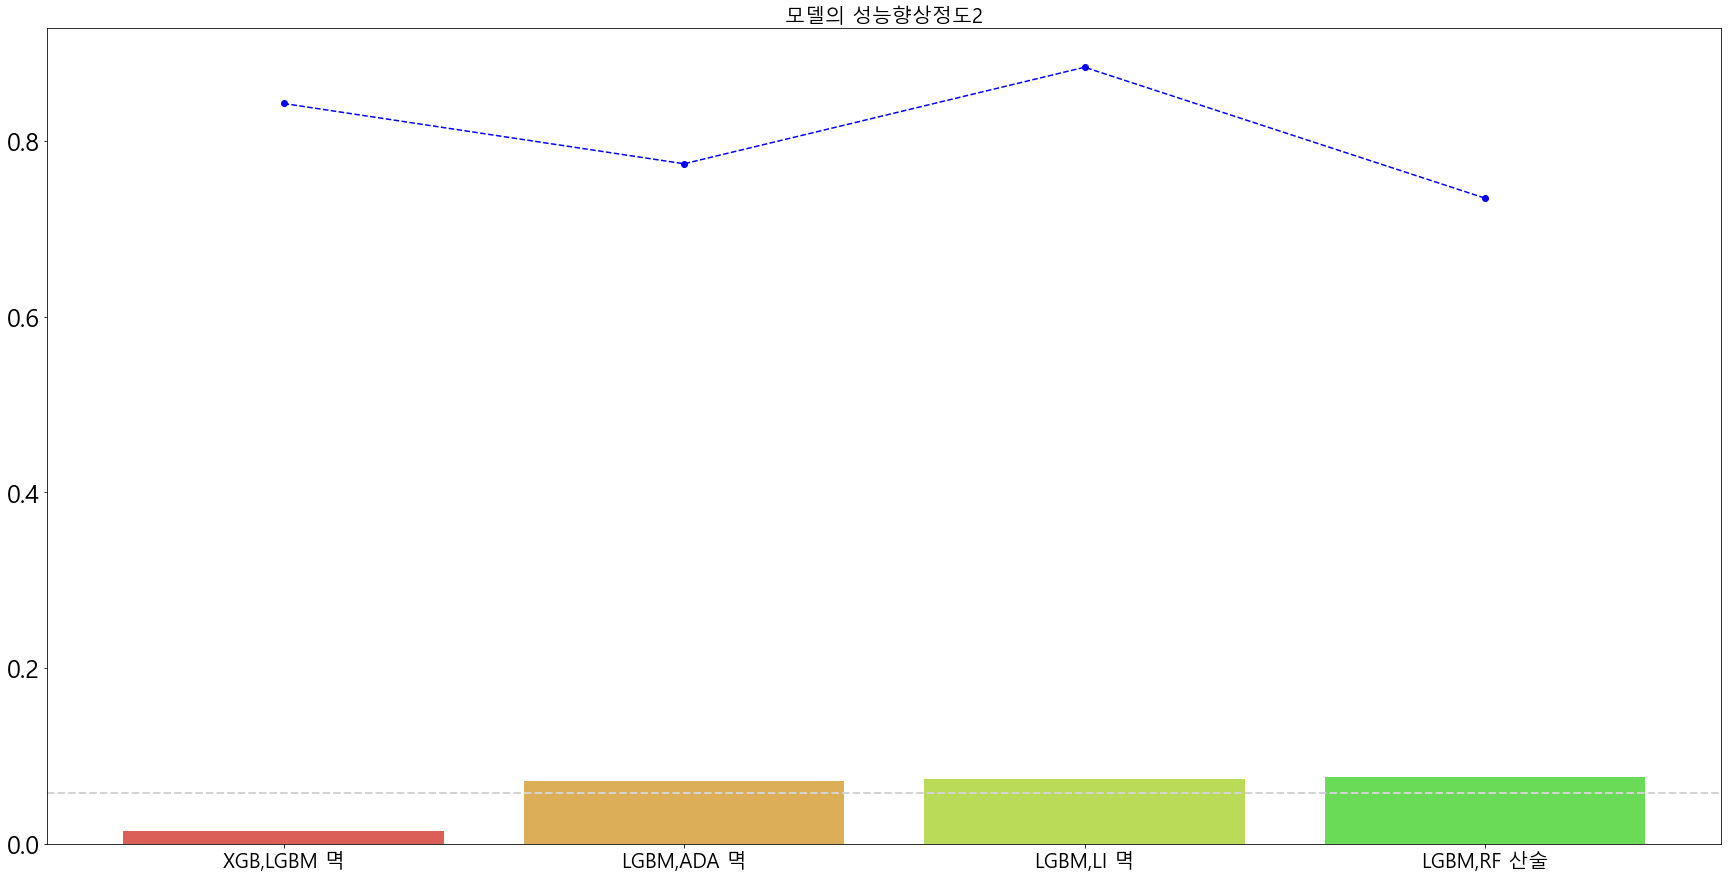

In [227]:
fig = plt.figure(figsize=(30,15))
plt.bar(ensemble_lgbm["model"], ensemble_lgbm["performance improvement2"],label = "성능향상",color=colors)
plt.title('모델의 성능향상정도2', fontsize=20) 
plt.axhline(0.05753200000000003,0 ,1, color='lightgray', linestyle='--', linewidth=2)
plt.plot(ensemble_lgbm["model"], ensemble_lgbm["corr_score"], color='b', 
         linestyle='--', marker='o',label = "상관관계")
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 25)

In [21]:
averageing_score_mean = ensemble_df["averaging_score"].mean()
print(averageing_score_mean)

0.9441940000000001


In [23]:
singlemodel1_score_mean = ensemble_df["singlemodel1_score"].mean()
print(singlemodel1_score_mean)

0.9093580000000001


In [122]:
singlemodel2_score_mean = ensemble_df["singlemodel2_score"].mean()
print(singlemodel2_score_mean)

1.0940940000000001


In [129]:
SM12_mean = (ensemble_df["singlemodel1_score"]+ensemble_df["singlemodel2_score"])/2
SM12_mean = SM12_mean.mean()
SM12_mean

1.0017260000000001

In [130]:
df = pd.DataFrame({'model':['averageing_score_mean','singlemodel1_score_mean',
                            'singlemodel2_score_mean','SM12_mean'],
                   'mean': [0.9441940000000001, 0.9093580000000001, 
                            1.0940940000000001, 1.0017260000000001]})
df

,model,mean
0,averageing_score_mean,0.944194
1,singlemodel1_score_mean,0.909358
2,singlemodel2_score_mean,1.094094
3,SM12_mean,1.001726


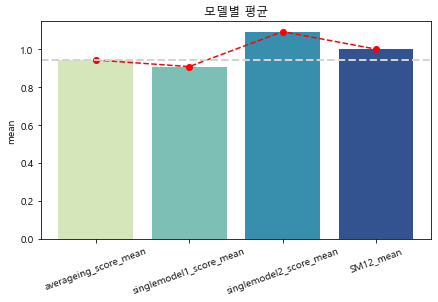

In [205]:
x = ['averageing_score_mean','singlemodel1_score_mean','singlemodel2_score_mean','SM12_mean']
y = [0.9441940000000001, 0.9093580000000001,1.0940940000000001, 1.0017260000000001]

plt.figure(figsize = (7,4))
sns.barplot(x, y, palette='YlGnBu')
plt.plot(df["model"], df["mean"], color='r',linestyle='--', marker='o',label = "추세선")
plt.axhline(0.9441940000000001,0 ,1, color='lightgray', linestyle='--', linewidth=2)
plt.title('모델별 평균')
plt.xticks(rotation = 20)
plt.ylabel('mean')
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.show()

모델들의 조합(총 10가지)을 만들고 산술,멱,가중,기하 평균으로 averaging한 리더보드 점수들 중, 가장 좋았던 averaging 결과들의 평균을 내고, 조합한 단일 모델들 중 성능이 좋았던 단일모델들의 평균과 성능이 좋지 않았던 단일모델들의 평균을 내보았다. 또한 성능이 좋았던 단일모델과 좋지 않았던 단일모델들의 평균을 내서 어느 정도의 차이가 있는지 보기 위해서 시각화를 해보았다. 

성능이 좋았던 단일모델들의 평균은 averaging한 결과의 평균보다 점수가 조금 더 좋게 나온것을 알 수 있다. 하지만, 성능이 좋지 않았던 단일모델들의 평균보다는 averaging한 결과의 평균의 점수가 훨씬 좋은것을 알 수 있다. 또한, averaging한 결과의 평균이 성능이 좋았던 단일모델들과 성능이 좋지 않았던 단일모델들의 평균보다 점수가 좋다는 것을 알 수 있다.   
결론 : 성능이 좋지 않은 단일모델들은 averaging을 하게 되면 성능이 크게 향상될 수 있다.


In [189]:
ensemble_df.corr()

,averaging_score,corr_score,singlemodel1_score,singlemodel2_score,performance improvement,SM12_score_mean,performance improvement2
averaging_score,1.000000,-0.183227,0.890210,0.766184,-0.049450,0.963226,0.239754
corr_score,-0.183227,1.000000,-0.053959,-0.224329,-0.230251,-0.175199,-0.039269
singlemodel1_score,0.890210,-0.053959,1.000000,0.444410,-0.499013,0.808668,0.037091
singlemodel2_score,0.766184,-0.224329,0.444410,1.000000,0.483160,0.886362,0.719723
performance improvement,-0.049450,-0.230251,-0.499013,0.483160,1.000000,0.059372,0.374764
SM12_score_mean,0.963226,-0.175199,0.808668,0.886362,0.059372,1.000000,0.491794
performance improvement2,0.239754,-0.039269,0.037091,0.719723,0.374764,0.491794,1.000000


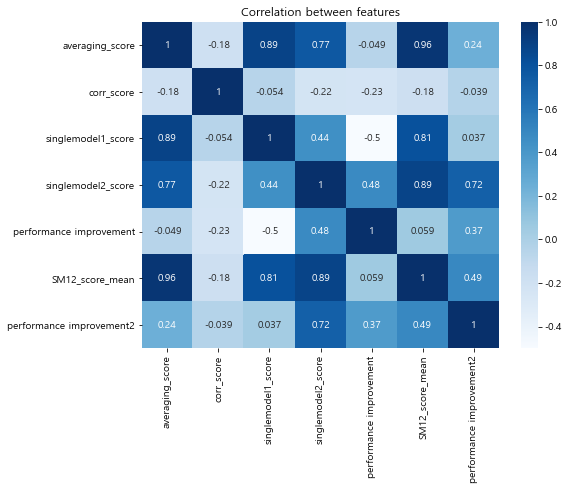

In [194]:
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_df.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between features")
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.show()

모델의 성능향상정도와 모델들의 상관관계의 상관관계는 -0.23으로 큰 상관관계는 없는 것으로 보인다. 
오히려 모델의 성능향상정도는 성능이 좋지 않았던 각 단일모델과의 상관관계가 0.48로 좋은 상관관계를 보인다. 

앞서 바차트에서 성능이 좋았던 단일모델들의 평균은 averaging한 결과의 평균보다 점수가 조금 더 좋게 나온것을 보았는데, 이 히트맵에서도 성능이 좋았던 단일모델들과 모델의 성능향상정도는 -0.5로 상관관계가 없는 것으로 보인다. 

